In [1]:
import scanpy as sc
import poisson_atac as patac
import os

[rank: 0] Global seed set to 0
/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/nasif12/home_if12/martensl/github_repos/scatac_poisson_private/poisson_atac/utils.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use("seaborn-poster")


In [2]:
data_path = '/s/project/transcription_factor_activity/data/neurips/anndata/'

In [3]:
adata = sc.read(os.path.join(data_path, 'neurips_atac.h5ad'))

/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


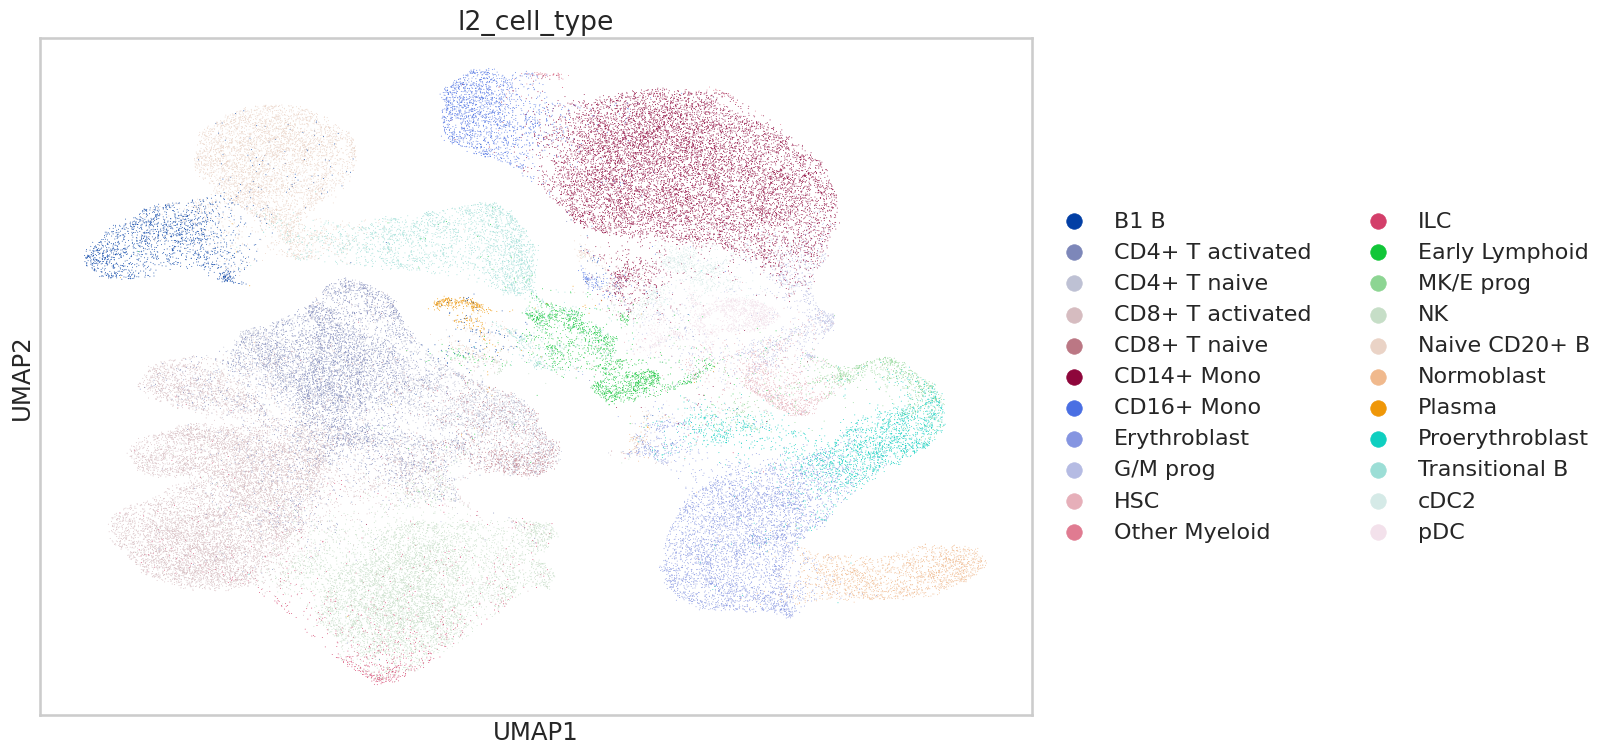

In [4]:
sc.pl.umap(adata, color='l2_cell_type')

## Filter for one batch for now

In [5]:
adata = adata[adata.obs.batch == 's1d1'].copy()

## Save var for narrow peak format

In [10]:
bed_file = adata.var_names.to_series().str.split('-', expand=True)
bed_file.columns = ['chr', 'start', 'end']

In [22]:
bed_file.start = bed_file.start.astype(int)
bed_file.end = bed_file.end.astype(int)

In [17]:
import numpy as np
import pandas as pd
add_on_df = pd.DataFrame(
    np.zeros((bed_file.shape[0], 7)), 
    index=bed_file.index, 
    columns=['A', 'B', 'C', 'D', 'E', 'F', 'G']
)

In [19]:
bed_file = bed_file.join(add_on_df)

In [28]:
bed_file.iloc[:, 9] = ((bed_file.end-bed_file.start)/2).astype(int)

/scratch/tmp/martensl/ipykernel_2146284/1385804418.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  bed_file.iloc[:, 9] = ((bed_file.end-bed_file.start)/2).astype(int)


In [31]:
bed_file.to_csv(
    '/s/project/transcription_factor_activity/data/chrom_bp_net/neurips/narrow_peak_test.bed', 
    header=None, 
    sep='\t',
    index=False
)

## Create embedding for this baexpand=

In [33]:
patac.model.PoissonVI.setup_anndata(adata, layer='counts', batch_key='batch')

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [36]:
model = patac.model.PoissonVI(adata)

In [37]:
model.train()

/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/modules/i12g/anaconda/envs/poisson_atac_new/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/modules/i12g/anaconda/envs/poisson_atac_new/lib ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0

Epoch 87/500:  17%|█▋        | 87/500 [07:24<35:09,  5.11s/it, loss=1.89e+04, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 45 records. Best score: 19564.768. Signaling Trainer to stop.


## Create embedding

In [38]:
X_emb = model.get_latent_representation()

In [40]:
adata.obsm['X_poissonvi'] = X_emb

/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


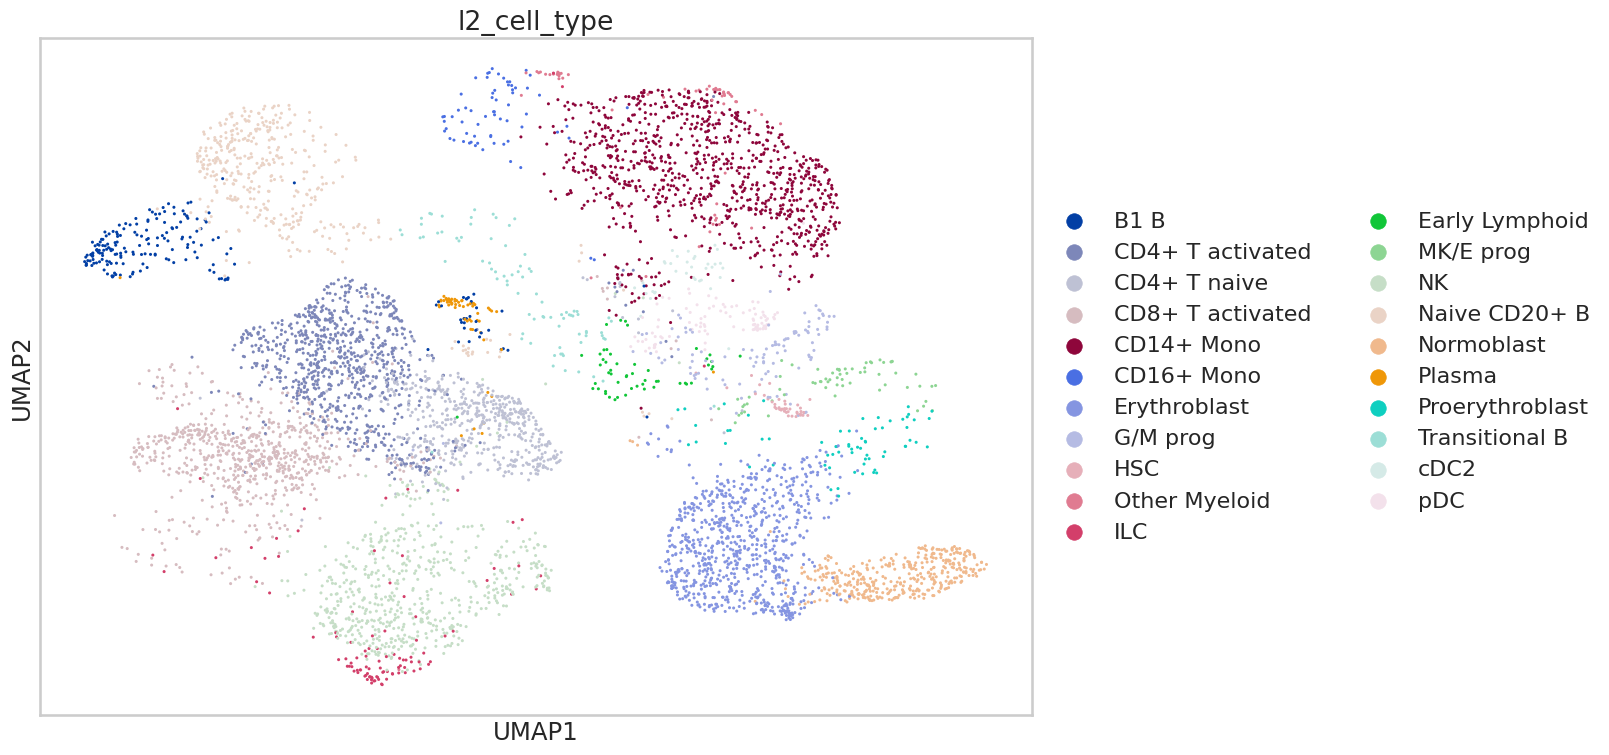

In [42]:
sc.pl.umap(adata, color='l2_cell_type')

/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/modules/i12g/anaconda/envs/poisson_atac_new/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/modules/i12g/anaconda/envs/poisson_atac

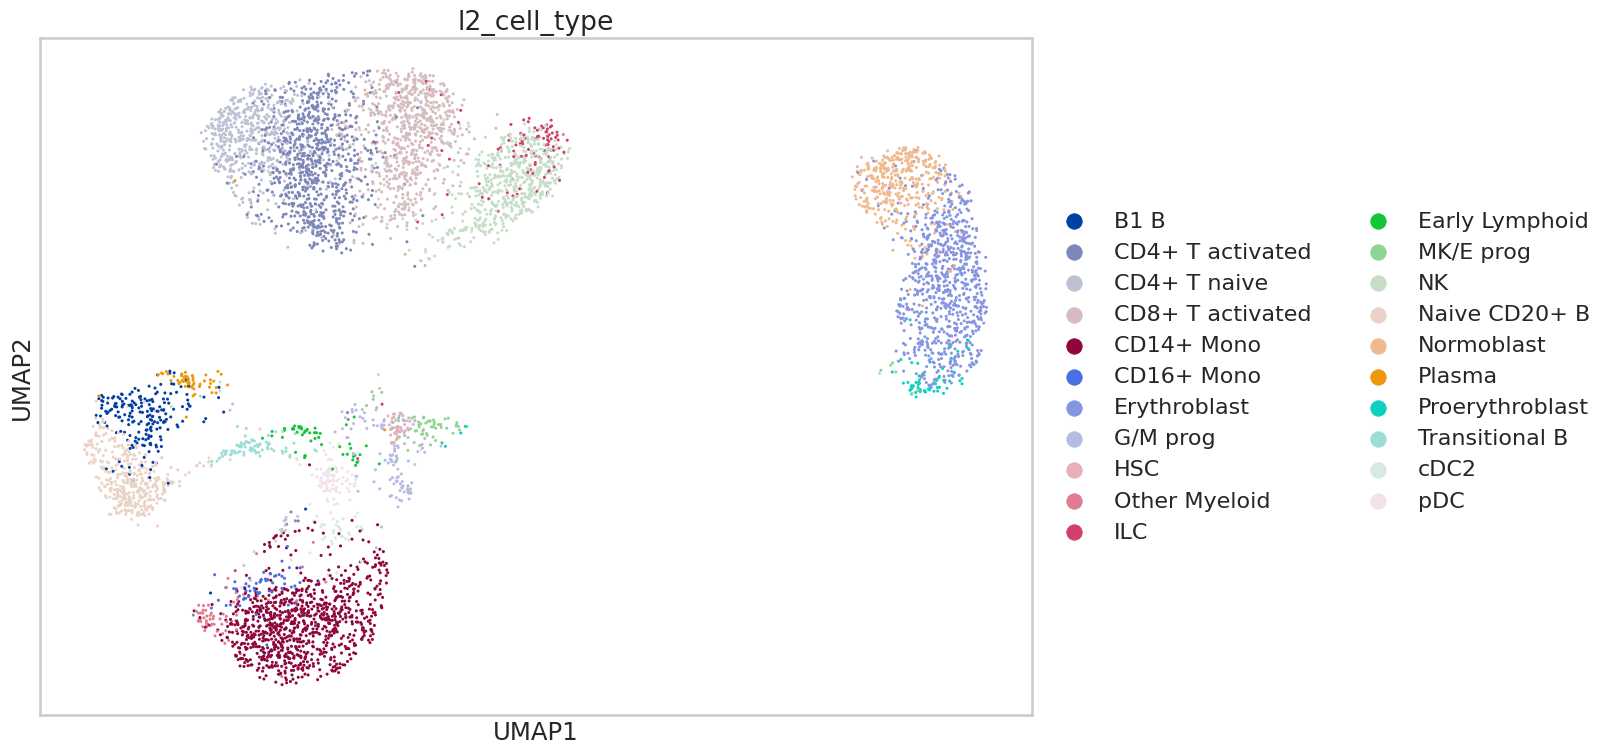

In [43]:
sc.pp.neighbors(adata, use_rep='X_poissonvi')
sc.tl.umap(adata)
sc.pl.umap(adata, color='l2_cell_type')

In [44]:
adata.write('/s/project/transcription_factor_activity/data/neurips/anndata/s1d1_atac.h5ad')